* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model as model
import Loaddata as Loaddata
import TrainVaTe as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=0.001, help='initial learning rate [default: 0.001]')
parser.add_argument('-L2', type=float, default=0.00001, help='L2 regularization [default: 0.00001]')
parser.add_argument('-epochs', type=int, default=5, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
#parser.add_argument('-hidden_size', type=int, default=128, help='size of hidden layers [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = 0.001
args.L2 = 0.00001
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]


 Current running on: Epoch  0 Training loss:  Average loss 0.41121733953030304
[1.605807108132546, 0.476449882270254, 0.4120332244092133, 0.4016084012090287, 0.38652546190455905, 0.3711858990835026, 0.37469667291449876, 0.3679482301543467, 0.3808967815314827, 0.35907978051458483, 0.35008244527084753, 0.40700029822206124, 0.32449285787863846, 0.3537980975822793, 0.34602617794042456, 0.3638065170990394, 0.3493361326440937, 0.3936789233522722, 0.3928619001418251, 0.32123484124515744, 0.34189600324300773, 0.37268262284709636, 0.3622918116933726, 0.35561606887499875, 0.3684098741062335, 0.37088245821694726, 0.3487333484257979, 0.3425286353341799, 0.32371239013649755] 
 train loss plot


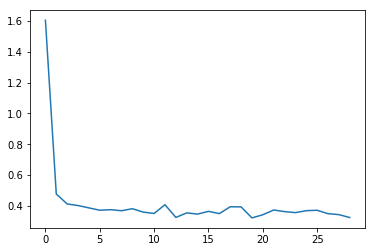


 Current running on: Epoch  0  Training auc: 0.7244260724618408


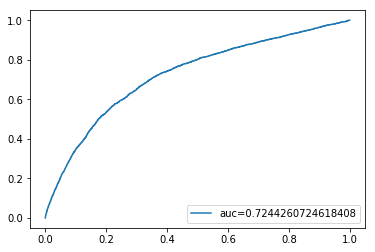


 Current running on: Epoch  0  validation auc: 0.6947388293562


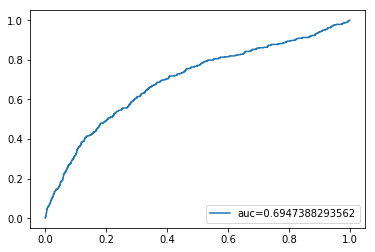


 Current running on: Epoch  0  test auc: 0.72172756437887


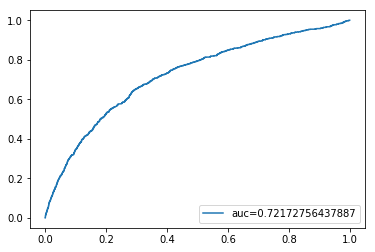


 Current running on: Epoch  1 Training loss:  Average loss 0.3385975628766236
[0.34315993762334984, 0.38097652894957357, 0.3506107035913192, 0.31252848075001294, 0.3278295626992895, 0.3650575881851114, 0.36735907249282274, 0.31840720233719916, 0.32905164543368026, 0.37377842040526504, 0.3257640100473076, 0.3561007790173171, 0.31994600140034074, 0.3556120806157342, 0.34782595007923967, 0.3299672203341906, 0.3235467363614189, 0.3156198164451757, 0.33443090339029596, 0.35186179641016135, 0.354028528232142, 0.34407984641490474, 0.34452589290522156, 0.30080434936201345, 0.3162143380942289, 0.3417839136137002, 0.33026297156335205, 0.31203982927116886, 0.3461552173965483] 
 train loss plot


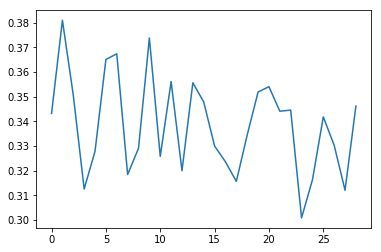


 Current running on: Epoch  1  Training auc: 0.7413879553235008


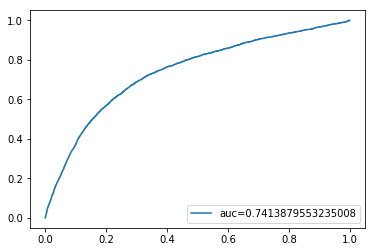


 Current running on: Epoch  1  validation auc: 0.7037056161810886


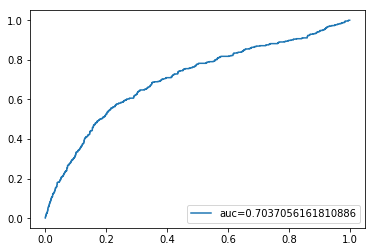


 Current running on: Epoch  1  test auc: 0.7574408302891049


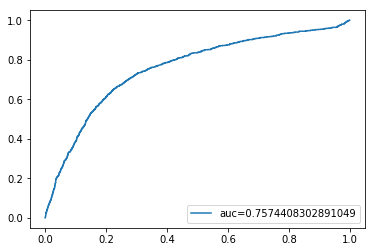


 Current running on: Epoch  2 Training loss:  Average loss 0.3294217593350172
[0.3625538460947937, 0.3200807719474542, 0.32134101330062687, 0.3283690791881886, 0.32635589240058777, 0.3379699214656612, 0.3391316932997506, 0.32152869722896626, 0.32999086924123594, 0.33115335477544433, 0.3241091693942435, 0.3523505840234284, 0.33460743292589906, 0.357720070991636, 0.32901954209674933, 0.2998732444489358, 0.37448381934936353, 0.3057707941263361, 0.322525203525481, 0.28717046105337796, 0.3091076469365289, 0.35724074057852795, 0.3067936850787755, 0.3345017549156919, 0.2778867605910638, 0.35047545709030237, 0.30377100034869364, 0.34177938138931235, 0.36556913290844206] 
 train loss plot


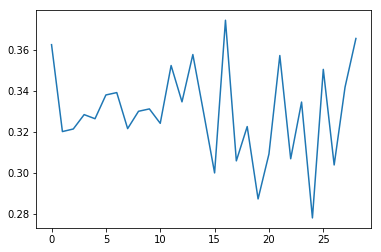


 Current running on: Epoch  2  Training auc: 0.7939023421368503


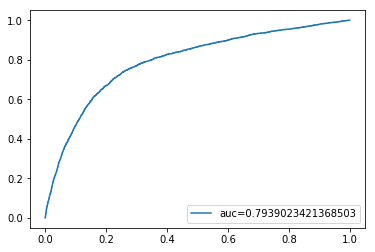


 Current running on: Epoch  2  validation auc: 0.765761135945996


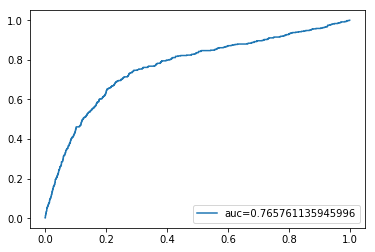


 Current running on: Epoch  2  test auc: 0.8010154256920459


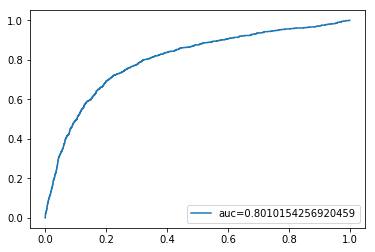


 Current running on: Epoch  3 Training loss:  Average loss 0.3244054409771112
[0.3080727640532207, 0.3203857542406299, 0.3338877906309076, 0.31289909754706846, 0.3381988901082123, 0.3094542042366377, 0.31125620719465347, 0.32628560128626666, 0.3320793197404919, 0.4015571434903141, 0.30178433726358617, 0.3024727870070383, 0.3201292434608538, 0.35934843375558967, 0.3067709118496823, 0.3053531724912629, 0.34961519452781464, 0.3269012750771981, 0.3460973250266179, 0.30777886131587, 0.3428275952760497, 0.31575740288707266, 0.3247417826941819, 0.31124765281080274, 0.30008385946490446, 0.3340425170648092, 0.32334638282878225, 0.29399572285544306, 0.3413865581502614] 
 train loss plot


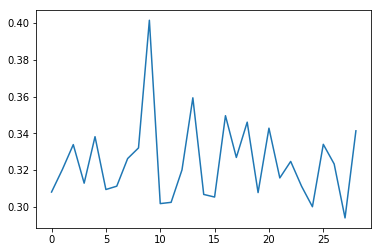


 Current running on: Epoch  3  Training auc: 0.7917475637720501


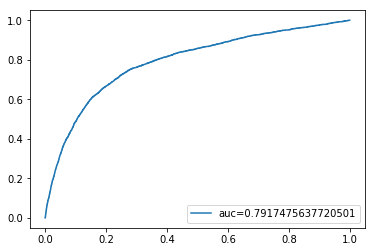


 Current running on: Epoch  3  validation auc: 0.7589210239731773


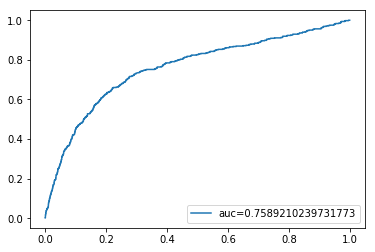


 Current running on: Epoch  3  test auc: 0.8003218909505851


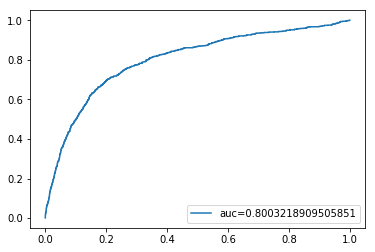


 Current running on: Epoch  4 Training loss:  Average loss 0.32151247570154917
[0.3274716853426908, 0.3297130608591033, 0.31149451440944825, 0.34060510742749206, 0.35097688783840614, 0.3019465429975771, 0.31157870535677556, 0.27750568488464833, 0.33894801648560063, 0.33541661357471025, 0.32468983744471736, 0.30419401841668015, 0.3372126684808645, 0.3364670947213003, 0.2582116785714962, 0.35188419937993753, 0.33593336977794935, 0.31461530658870923, 0.33460184488222194, 0.3216324930059718, 0.32569909437972244, 0.32624858800339823, 0.3137041650208166, 0.32095017860871666, 0.32899701235612405, 0.3303448789130198, 0.3047259335868348, 0.32839114799038926, 0.2997014660396066] 
 train loss plot


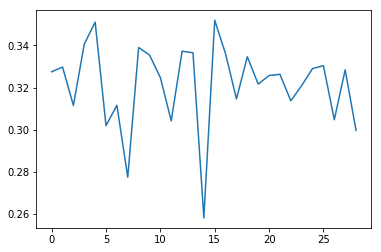


 Current running on: Epoch  4  Training auc: 0.7984708883947937


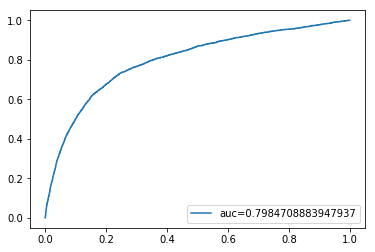


 Current running on: Epoch  4  validation auc: 0.7643530061685592


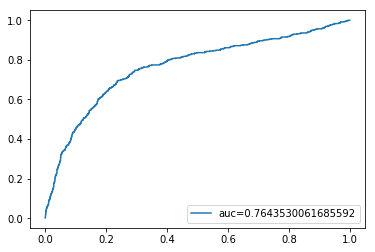


 Current running on: Epoch  4  test auc: 0.8014563209766623


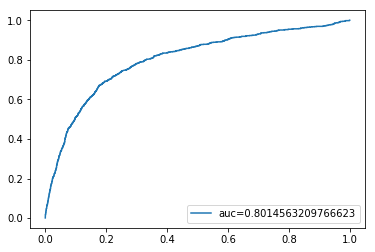


 Current running on: Epoch  5 Training loss:  Average loss 0.31951413273743096
[0.3549948512793562, 0.3137525281678268, 0.3039048813361287, 0.32177144387317375, 0.3288805169702069, 0.32968045852083583, 0.32251541205699324, 0.30858352865420247, 0.328899757395372, 0.30175269865246335, 0.2904586194171253, 0.34734437086610526, 0.28797447993802006, 0.3541770007313316, 0.3054061349094288, 0.2856605107122177, 0.3601789620862115, 0.30350830486214664, 0.3063510251996363, 0.35624807822183097, 0.32121485299230423, 0.32864057428409615, 0.29329082234253384, 0.32212993468161677, 0.32747899058768143, 0.3179452369981891, 0.2866330638364309, 0.34206633854170937, 0.3144664712703209] 
 train loss plot


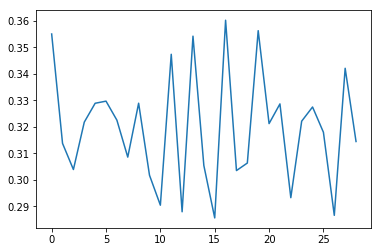


 Current running on: Epoch  5  Training auc: 0.7823801889879868


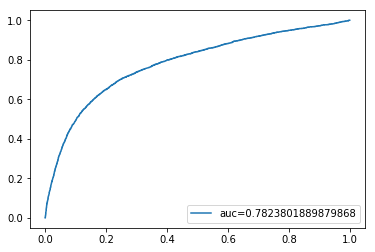


 Current running on: Epoch  5  validation auc: 0.7388558576723402


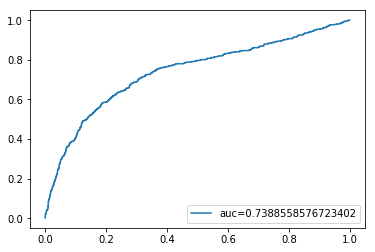


 Current running on: Epoch  5  test auc: 0.7876547688620918


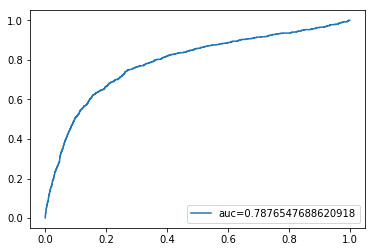


 Current running on: Epoch  6 Training loss:  Average loss 0.31798237467068985
[0.33147901610395913, 0.34201375240811466, 0.31288558447316145, 0.31269884413460386, 0.2844449238159941, 0.35851031589848237, 0.2990734760992154, 0.3396641263614124, 0.3341434397362211, 0.2991179980915622, 0.298794276049171, 0.3220821328114858, 0.318888076718732, 0.35892376156274286, 0.25073619614244336, 0.3378312639881515, 0.3072673505440944, 0.32505179736001355, 0.3071775769932219, 0.31118205872650434, 0.3363234655401865, 0.33705656651943355, 0.33376576091493915, 0.29124541665510945, 0.3030339658091816, 0.28668869746671954, 0.32904982503270197, 0.31678289478616545, 0.3355763047062835] 
 train loss plot


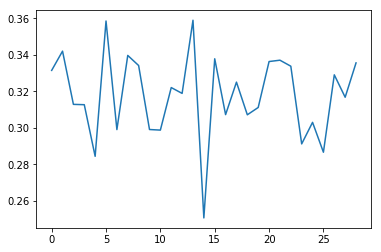


 Current running on: Epoch  6  Training auc: 0.8010099471269994


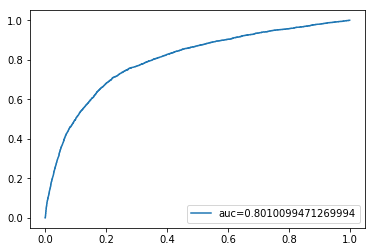


 Current running on: Epoch  6  validation auc: 0.765084665373832


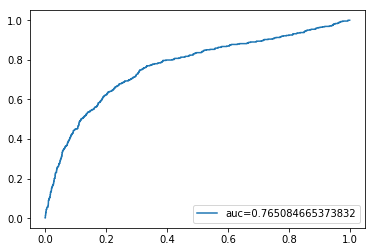


 Current running on: Epoch  6  test auc: 0.8066941025683563


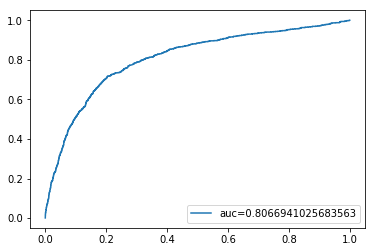


 Current running on: Epoch  7 Training loss:  Average loss 0.31777902258622
[0.34330125525037736, 0.2962286404321516, 0.2879558430249233, 0.318813083510606, 0.320618194339223, 0.3059660473532832, 0.3239995422552197, 0.3032339617416983, 0.3320023410777059, 0.3261945966267599, 0.30422226964224863, 0.31717662496344684, 0.31496476927651385, 0.3007544273582063, 0.3211274084310183, 0.32138228070056024, 0.33683111149990236, 0.35393078790214927, 0.3552905248650632, 0.3208169057456944, 0.3336197374570577, 0.3088208832342209, 0.3394255582260803, 0.31032683279330375, 0.31674197798865045, 0.3148667713818213, 0.2729107909863799, 0.286135944528977, 0.32793254240713465] 
 train loss plot


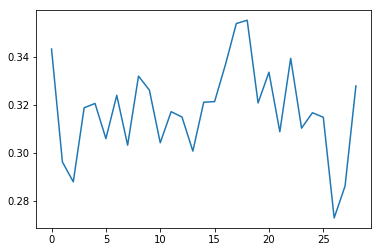


 Current running on: Epoch  7  Training auc: 0.8043168837229311


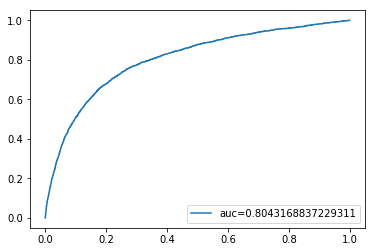


 Current running on: Epoch  7  validation auc: 0.7699866181225263


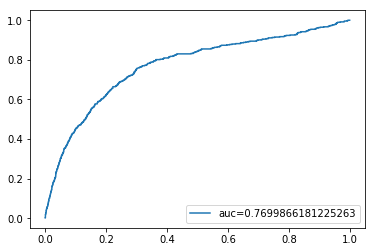


 Current running on: Epoch  7  test auc: 0.8068667893876199


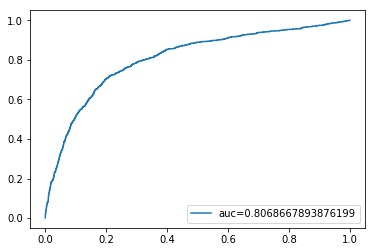


 Current running on: Epoch  8 Training loss:  Average loss 0.3157914598172036
[0.2663399935721509, 0.31283877456859044, 0.3072822338204444, 0.3302051024313333, 0.307223731492694, 0.3333890276944585, 0.32023817595302173, 0.30352882309515555, 0.3124150084320172, 0.28365751331279854, 0.2922915858357205, 0.34732915619738197, 0.31999229377942356, 0.3117380320439547, 0.31931153825056935, 0.30364927146713816, 0.3351697419077225, 0.30749131666842183, 0.29863413697351654, 0.33870572811361355, 0.33635448635861326, 0.3226131484970701, 0.32412877596717876, 0.32477932056487135, 0.3320375960682096, 0.28276275387917305, 0.3302744624432953, 0.3163404671370395, 0.33723013817332664] 
 train loss plot


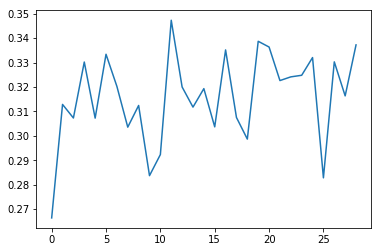


 Current running on: Epoch  8  Training auc: 0.8051613445117053


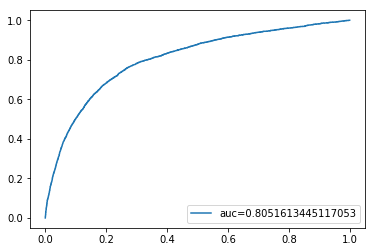


 Current running on: Epoch  8  validation auc: 0.7704068167251066


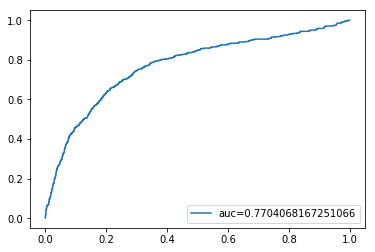


 Current running on: Epoch  8  test auc: 0.8047441692363462


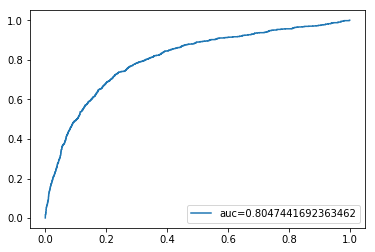


 Current running on: Epoch  9 Training loss:  Average loss 0.3162203753645467
[0.3132678720310505, 0.3114050235818158, 0.3280466964402699, 0.28720907432866716, 0.29968503200354835, 0.36007366321220546, 0.32088254333059013, 0.31311302609305136, 0.31390008236738903, 0.33054669177073814, 0.30823666896729696, 0.34724285006053107, 0.3426344922282733, 0.298439691260894, 0.29712309972951473, 0.2891419024584634, 0.31878877979260867, 0.3069953658730449, 0.34462936338328043, 0.2998397185599194, 0.28577317458249124, 0.30584872705150157, 0.2795075630482743, 0.3371720830295275, 0.317002797733549, 0.3315419361879467, 0.3518416903836651, 0.3041636688586276, 0.32633760722312083] 
 train loss plot


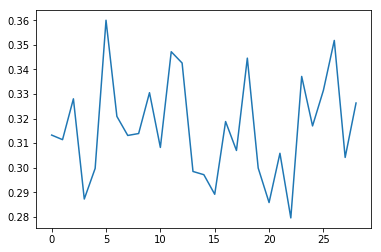


 Current running on: Epoch  9  Training auc: 0.8062421960638969


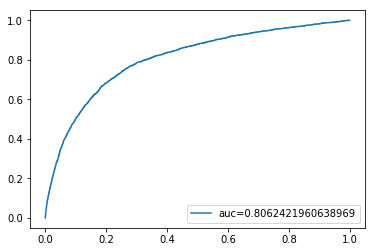


 Current running on: Epoch  9  validation auc: 0.7725258416676365


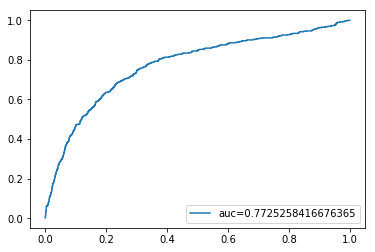


 Current running on: Epoch  9  test auc: 0.8084433384631743


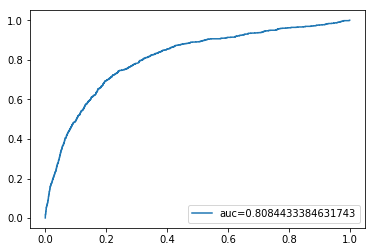


 Current running on: Epoch  10 Training loss:  Average loss 0.31460939505118835
[0.3065303646456098, 0.2577121457050258, 0.3421850863065959, 0.3427030294108853, 0.32019526145310234, 0.29563624116132453, 0.32975080816429786, 0.30648255272714936, 0.30990396333186676, 0.26676793624608797, 0.3175798610282068, 0.3123482526558772, 0.3407063386633381, 0.34554386035048723, 0.32465550697084516, 0.3489246927694635, 0.3320328366987997, 0.3081728596102621, 0.30657959665246387, 0.2989431476101837, 0.3402875190081643, 0.34179702018327224, 0.3174268448628509, 0.28318680051853606, 0.3198086402818783, 0.2984773426163833, 0.2957459209825829, 0.30266249870585304, 0.3109255271630685] 
 train loss plot


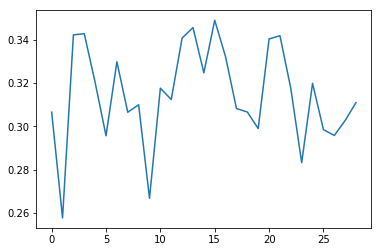


 Current running on: Epoch  10  Training auc: 0.8042639131995737


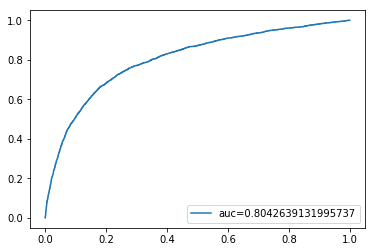


 Current running on: Epoch  10  validation auc: 0.7643781415856186


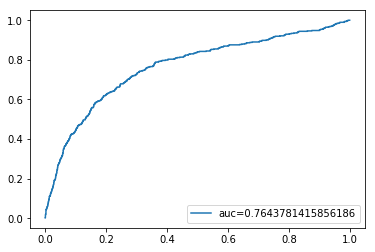


 Current running on: Epoch  10  test auc: 0.8072726713998265


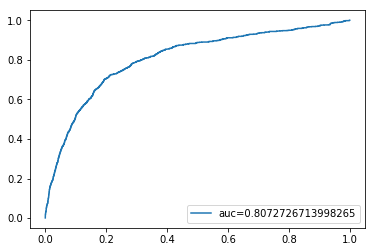


 Current running on: Epoch  11 Training loss:  Average loss 0.3175053671958861
[0.28143514233384637, 0.2980298034690479, 0.3382844823833611, 0.3276027192047741, 0.31221773021542687, 0.3241786029638922, 0.3093827657757356, 0.2849729379969476, 0.3317054986881931, 0.3533115247665094, 0.3226684229677712, 0.32323882206011306, 0.28423125781768793, 0.29947659078861033, 0.3411799432805294, 0.31013868340344425, 0.31423279342151544, 0.3037648564244555, 0.33720695481076485, 0.31192210395265235, 0.3338816618788572, 0.32460368064327055, 0.27977980831611876, 0.313531542903278, 0.3504183273267772, 0.3281977193665811, 0.31953314951528783, 0.3172143338820888, 0.3313137881231603] 
 train loss plot


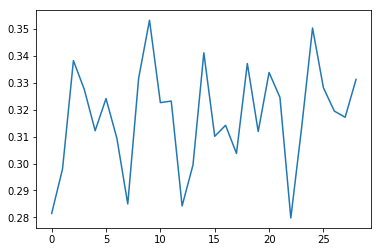


 Current running on: Epoch  11  Training auc: 0.8030944057749724


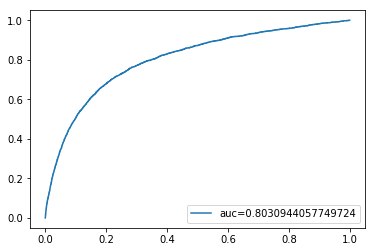


 Current running on: Epoch  11  validation auc: 0.7665982546184963


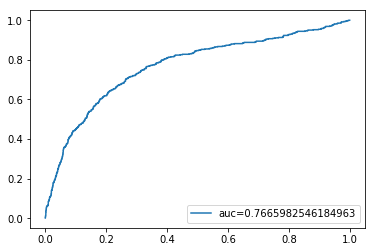


 Current running on: Epoch  11  test auc: 0.799300591187207


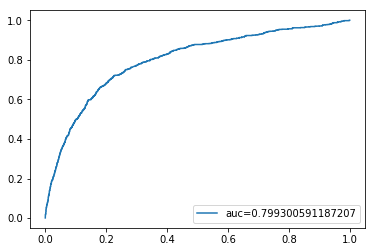


 Current running on: Epoch  12 Training loss:  Average loss 0.3158400880026857
[0.305085150149764, 0.29019412271669376, 0.3263953360424948, 0.2742458512181239, 0.3455315432938193, 0.3369081946235194, 0.2947601069743564, 0.3308144902584036, 0.2832568482114075, 0.3470784931099371, 0.2987278965974622, 0.29769437411383476, 0.30558104470619674, 0.3341493968942159, 0.3155862422062237, 0.3421121195072539, 0.34046799934906447, 0.31628172897433904, 0.30664512414536965, 0.31862546710262724, 0.272146033562673, 0.3294543015630552, 0.3583012809354377, 0.32165816470735215, 0.30945864670361706, 0.28958861618662163, 0.33534919804905644, 0.33236388819842866, 0.3009008919765356] 
 train loss plot


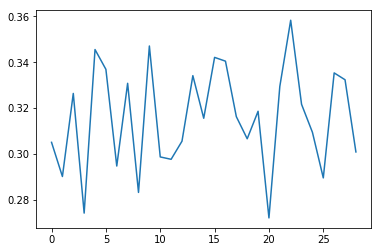


 Current running on: Epoch  12  Training auc: 0.8036939932610867


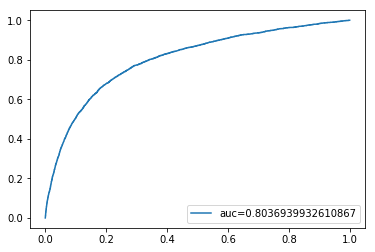


 Current running on: Epoch  12  validation auc: 0.7673064176730396


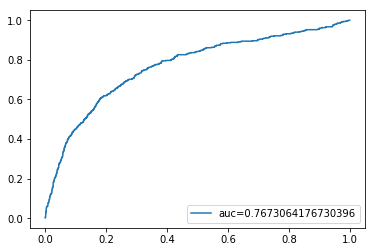


 Current running on: Epoch  12  test auc: 0.8013739887962967


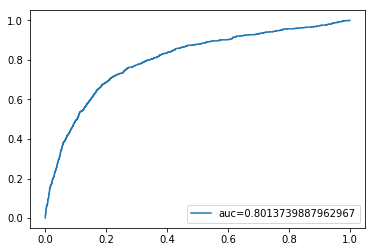


 Current running on: Epoch  13 Training loss:  Average loss 0.31543416223779647
[0.31334066873767946, 0.3187374200035685, 0.3093476941858462, 0.32808996088604103, 0.3228542746314488, 0.3067708923749965, 0.3022823593817366, 0.30182662435068325, 0.3048831595779111, 0.31902804889591607, 0.3240344504332338, 0.31199683791985067, 0.2917270173739118, 0.32228766909744105, 0.32138420847213217, 0.29009510179924836, 0.33433692733723364, 0.3227287958230445, 0.3318604116510321, 0.328732646488259, 0.3351613726701189, 0.2914439016080955, 0.3340882629825319, 0.330769799670652, 0.3241642642219131, 0.2809971146984753, 0.31547700791303596, 0.31187040901806923, 0.3172734026919909] 
 train loss plot


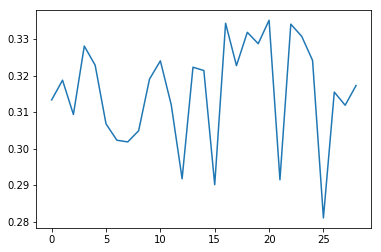


 Current running on: Epoch  13  Training auc: 0.8063363042351153


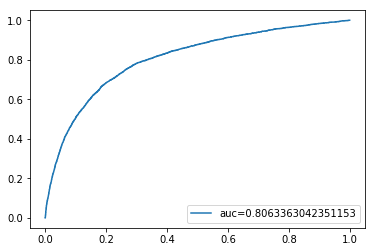


 Current running on: Epoch  13  validation auc: 0.7688189140734839


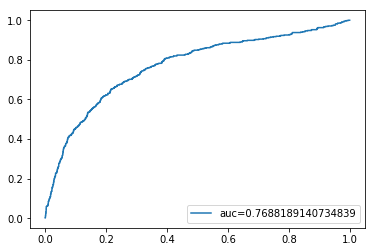


 Current running on: Epoch  13  test auc: 0.8059601155995483


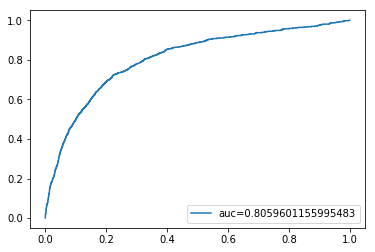


 Current running on: Epoch  14 Training loss:  Average loss 0.31467433274136314
[0.3056921273903872, 0.31770033786518936, 0.3390072698558861, 0.3523745190050795, 0.3218278575419972, 0.3208818837534045, 0.2816556078192084, 0.29215510683840357, 0.29346350861456333, 0.3125463306632255, 0.3014300454351507, 0.3254555072332223, 0.33236574714645944, 0.32626227321266493, 0.3028434331535245, 0.3064723059470452, 0.31410714251089983, 0.29771262468640225, 0.3359306286932524, 0.320741818411425, 0.3193604106937902, 0.3116476967010147, 0.3026535733714336, 0.3127424462213635, 0.28730381944231703, 0.3431044059359756, 0.3179904201104787, 0.31014407868920535, 0.3199827225565614] 
 train loss plot


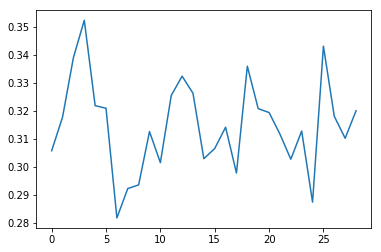


 Current running on: Epoch  14  Training auc: 0.8039896337608733


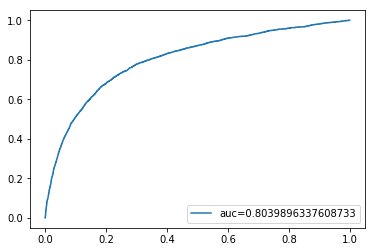


 Current running on: Epoch  14  validation auc: 0.762367308220866


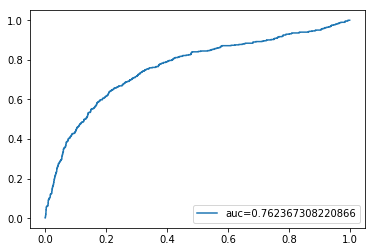


 Current running on: Epoch  14  test auc: 0.801519072919253


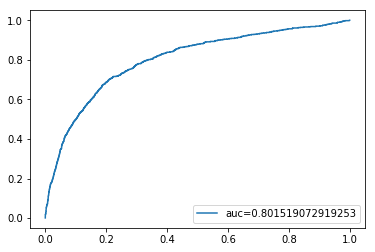


 Current running on: Epoch  15 Training loss:  Average loss 0.31388790251863496
[0.2622661882588281, 0.33111448205780664, 0.3354608590831544, 0.30539037949711345, 0.2991038565154467, 0.34624996216690473, 0.3053401326972175, 0.3430535715674281, 0.3392344802856096, 0.30192495293532556, 0.3248053671142916, 0.312683027209297, 0.32025063381180635, 0.3171694630006789, 0.3041036852336199, 0.3358134682323432, 0.2863109572415992, 0.316305578009393, 0.3021180868261374, 0.33164366240477827, 0.29354888870727164, 0.30038527334260745, 0.315224278118014, 0.32776364991304047, 0.3119824692321713, 0.30341377379087203, 0.30616617148395014, 0.34575710482560684, 0.27816476947809954] 
 train loss plot


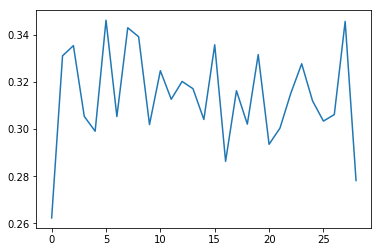


 Current running on: Epoch  15  Training auc: 0.8061726232373179


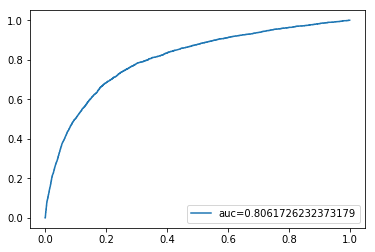


 Current running on: Epoch  15  validation auc: 0.7697084892685429


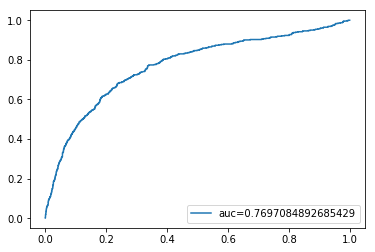


 Current running on: Epoch  15  test auc: 0.8083689607544048


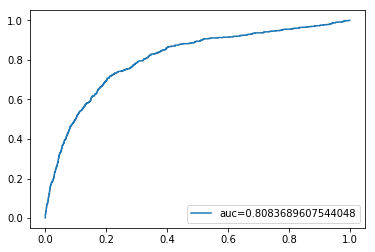


 Current running on: Epoch  16 Training loss:  Average loss 0.31447495862076347
[0.3030649945313853, 0.330627481269775, 0.33436723110662026, 0.31428548236681675, 0.3099592306322145, 0.28410008672043774, 0.2999991656401229, 0.3127372027119701, 0.30966520005341597, 0.33459457924673913, 0.31953938119991654, 0.3322277494035863, 0.3294505254775367, 0.3630408170036358, 0.2857002679643457, 0.3134386835047395, 0.31197448265770733, 0.2959633465861584, 0.2921001040594422, 0.33225930748237736, 0.2720987652416677, 0.3354411810907532, 0.3110470229170278, 0.3234832186272579, 0.3143220383719927, 0.30911367734245504, 0.3130995034444196, 0.3487044473336846, 0.28336862601393803] 
 train loss plot


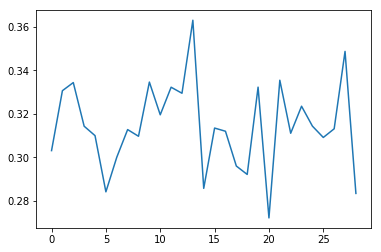


 Current running on: Epoch  16  Training auc: 0.8061651596697703


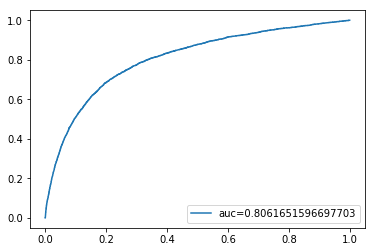


 Current running on: Epoch  16  validation auc: 0.7629880437378114


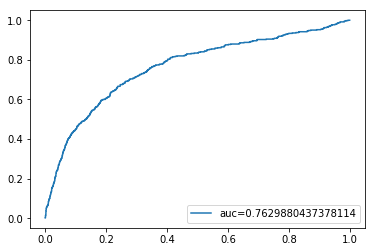


 Current running on: Epoch  16  test auc: 0.8031665323698044


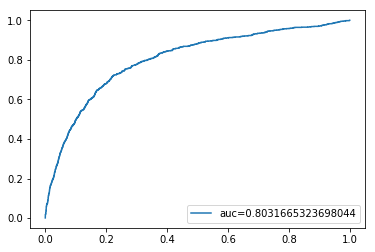


 Current running on: Epoch  17 Training loss:  Average loss 0.3142031550779118
[0.31107696855580796, 0.3014516685748834, 0.3093197456017284, 0.32928459518090664, 0.31004241441829433, 0.335450076041835, 0.3148756895724655, 0.3060415242995623, 0.3118675868127702, 0.3253457645924121, 0.3123751134060191, 0.32520692761450876, 0.31907812568049776, 0.3129842225573375, 0.2881847867665857, 0.3307541404792648, 0.26236270172311854, 0.31425695103923296, 0.3226358507479896, 0.3002273240459483, 0.3212596479233489, 0.3097287220293285, 0.31802490908047126, 0.32091217382450304, 0.33944802845642424, 0.3029111336352966, 0.32488556663505597, 0.33264359934287496, 0.29925553862096965] 
 train loss plot


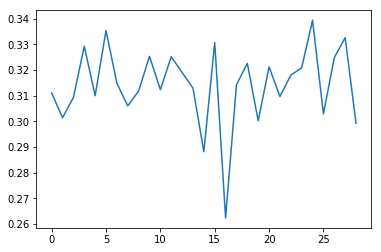


 Current running on: Epoch  17  Training auc: 0.8063660197971156


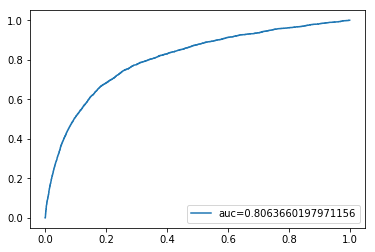


 Current running on: Epoch  17  validation auc: 0.7649846701277043


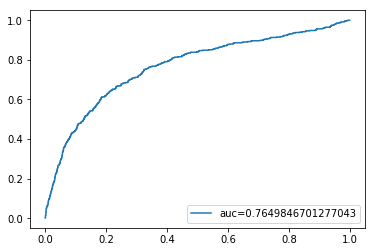


 Current running on: Epoch  17  test auc: 0.8034479982878169


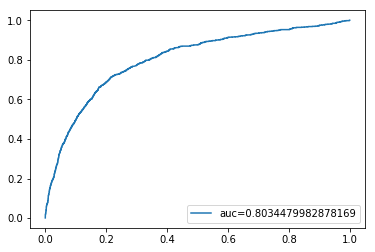


 Current running on: Epoch  18 Training loss:  Average loss 0.3142096075594464
[0.31659998111111987, 0.2963219223898486, 0.3025037556191819, 0.33626618545404924, 0.3262543326570803, 0.286367843449927, 0.3127402725865886, 0.3218691281856136, 0.2960140235007892, 0.33211477694365865, 0.3299404791720808, 0.31699808402724694, 0.3170039088620722, 0.2785242413805701, 0.30968563559372864, 0.3223666722462619, 0.3356605917768593, 0.28151566323024146, 0.32869802098143236, 0.2937555977234069, 0.3262918437024512, 0.29479459271872677, 0.31582561572360873, 0.3097050216837546, 0.32871312875094033, 0.3150283771609331, 0.3537492841968043, 0.29153730481797924, 0.3352323335769906] 
 train loss plot


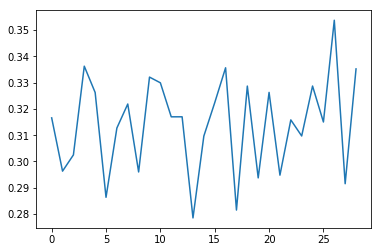


 Current running on: Epoch  18  Training auc: 0.8043021646501198


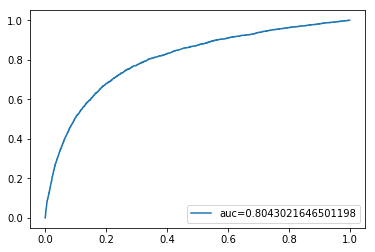


 Current running on: Epoch  18  validation auc: 0.7605143908458998


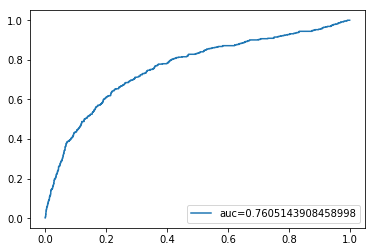


 Current running on: Epoch  18  test auc: 0.7990215048119794


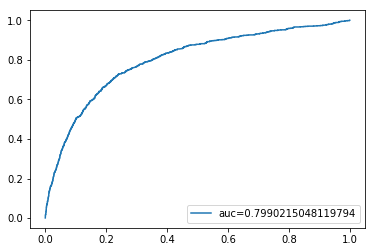


 Current running on: Epoch  19 Training loss:  Average loss 0.31467985776550544
[0.3349518576361406, 0.3122158174613123, 0.3060899841365317, 0.29355725775195607, 0.32356345897868416, 0.3151174090276836, 0.32042030736805466, 0.3405547180337092, 0.28664580432694176, 0.3317795085213229, 0.3152239773980064, 0.3190176382295049, 0.29187386498326484, 0.30256439724518913, 0.29041385351716553, 0.28186090132456015, 0.3666459450807342, 0.31994104615891183, 0.3234015932052715, 0.31872734748462883, 0.34228723393350213, 0.3019010537990753, 0.30561457484547466, 0.3084080206418419, 0.3248980928684796, 0.2941697491184295, 0.3449572644715081, 0.2856152145602076, 0.32329798309156493] 
 train loss plot


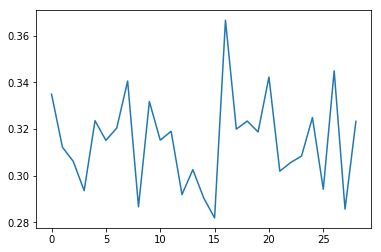


 Current running on: Epoch  19  Training auc: 0.8050482973377758


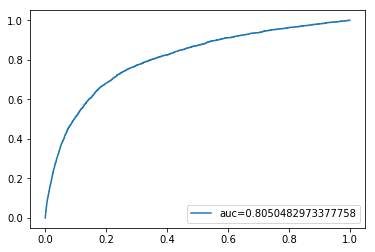


 Current running on: Epoch  19  validation auc: 0.7636612357773155


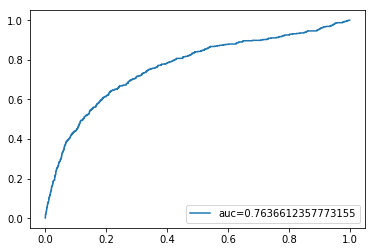


 Current running on: Epoch  19  test auc: 0.8062451168382703


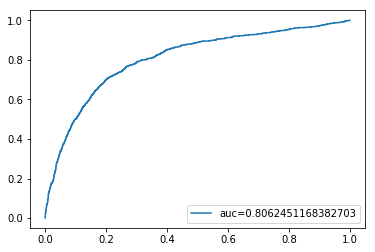

In [8]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    current_loss, train_loss = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    train_auc, y_real, y_hat = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    TVT.auc_plot(y_real, y_hat)
    valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    TVT.auc_plot(y_real, y_hat)
    test_auc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    TVT.auc_plot(y_real, y_hat)
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)

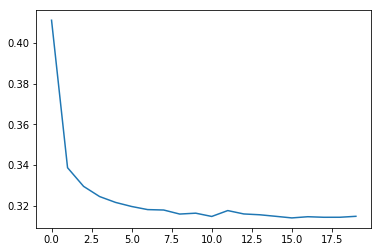

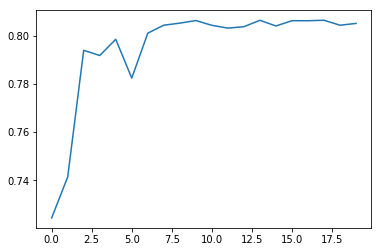

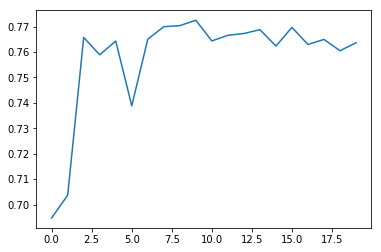

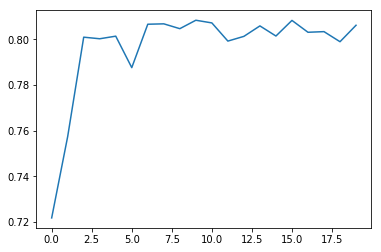

In [15]:
# average losses, training auc, validation auc and test auc with epochs
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)